In [1]:

import os
import sys
import argparse
import traceback


import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from itertools import combinations, permutations

import cmbnet.utils.utils_plotting as utils_plotting
import cmbnet.utils.utils_evaluation as utils_eval
import ast


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)


In [2]:
eval_dir = "../../data-misc/evaluations"

l1_dirs = ["Scratch-Pretrained-FineTuned"]  # winner
l2_dirs = ["predict_cmb_valid", "predict_cmb_dou", "predict_cmb_crb"]
l3_dirs = ["valloss"]
l4_dirs = [
    "Cerebellum",
    "Thalamus",
    "Basalgangliagreymatter",
    "Brainstem",
    "Subcorticalwhitematter",
    "CortexORgrey-whitejunction",
]
l4_names = [
    "Cerebellum",
    "Thalamus",
    "Basal ganglia grey matter",
    "Brainstem",
    "Subcortical white matter",
    "Cortex / grey-white junction",
]
(
    df_classification,
    df_detection,
    df_segmentation,
    detection_details,
    segmentation_details,
    cmb_results,
) = utils_eval.load_evaluation_data_advanced(
    eval_dir, l1_dirs, l2_dirs, l3_dirs, l4_dirs, l4_names
)

In [3]:
# Flatten the data into a list
flattened_data = []
for key, entries in detection_details.items():
    if not entries:
        continue
    for entry in entries:
        # Combine key tuple and entry dictionary
        combined_entry = dict(zip(['Model', 'Dataset', 'Criteria', 'Location'], key))
        combined_entry.update(entry)
        flattened_data.append(combined_entry)

# Create a DataFrame
df_detection_serieslevel = pd.DataFrame(flattened_data)


# Aggregated tables

### Micro average

In [4]:
dataset = ["dou", "crb", "valid"]
model = ["Scratch-Pretrained-FineTuned"]
locations = [
    "Cerebellum",
    "Thalamus",
    "Basal ganglia grey matter",
    "Brainstem",
    "Subcortical white matter",
    "Cortex / grey-white junction",
]
criteria = ["valloss"]
typemetric = ""
df_tmp = df_detection.copy()

selected = df_tmp[
    (df_tmp["Dataset"].isin(dataset))
    & (df_tmp["Model"].isin(model))
    & (df_tmp["Criteria"].isin(criteria))
    & (df_tmp["Location"].isin(locations))
]

selected = df_tmp[(df_tmp['Dataset'].isin(dataset)) & (df_tmp['Model'].isin(model)) & (df_tmp['Criteria'].isin(criteria))]
selected = selected[selected['Metric'].str.contains(typemetric)]
selected = selected[selected["Location"]=="Cerebellum"]
selected = selected[['Dataset', 'Location', 'Metric', 'Mean', 'Std.']]
selected

,Dataset,Location,Metric,Mean,Std.
0,valid,Cerebellum,Micro - Precision,0.533333,NaN
1,valid,Cerebellum,Micro - Recall,0.888889,NaN
2,valid,Cerebellum,Micro - F1,0.666667,NaN
3,valid,Cerebellum,Micro - FPavg,1.000000,NaN
4,valid,Cerebellum,Micro - FPcmb,0.777778,NaN
5,valid,Cerebellum,Micro - TP,8.000000,NaN
6,valid,Cerebellum,Micro - FP,7.000000,NaN
7,valid,Cerebellum,Micro - FN,1.000000,NaN
8,valid,Cerebellum,Micro - n_true_cmb,9.000000,NaN
9,valid,Cerebellum,Micro - n_pred_cmb,15.000000,NaN


In [5]:
dataset = ["dou", "crb", "valid"]
model = ["Scratch-Pretrained-FineTuned"]
locations = [
    "Cerebellum",
    "Thalamus",
    "Basal ganglia grey matter",
    "Brainstem",
    "Subcortical white matter",
    "Cortex / grey-white junction",
]
criteria = ["valloss"]
typemetric = "Macro - "
df_tmp = df_detection.copy()

selected = df_tmp[
    (df_tmp["Dataset"].isin(dataset))
    & (df_tmp["Model"].isin(model))
    & (df_tmp["Criteria"].isin(criteria))
    & (df_tmp["Location"].isin(locations))
]
selected = selected[selected["Metric"].str.contains(typemetric)]
table4results = selected[["Model", "Dataset", "Metric", "Mean", "Std.", "Location"]]
table4results["Mean - 2"] = table4results["Mean"].round(2).astype(str)
table4results["Metric"] = table4results["Metric"].str.replace(typemetric, "")
table4results_final = (
    table4results.pivot_table(
        index=["Dataset", "Location"],
        columns="Metric",
        values="Mean - 2",
        aggfunc="first",  # Since there should be only one entry per group, 'first' is a safe choice here
    )
    .reset_index()
    .sort_values(by=["Dataset", "Location"])
)
table4results_final[["Dataset", "Location", "Precision", "Recall", "F1", "FPcmb"]]

Metric,Dataset,Location,Precision,Recall,F1,FPcmb
0,crb,Basal ganglia grey matter,0.33,0.2,1.0,0.0
1,crb,Brainstem,1.0,0.25,0.67,0.0
2,crb,Cerebellum,1.0,0.53,0.93,0.0
3,crb,Cortex / grey-white junction,0.66,0.3,0.56,0.05
4,crb,Subcortical white matter,0.57,0.22,0.59,0.19
5,crb,Thalamus,0.5,0.5,0.72,0.3
6,dou,Basal ganglia grey matter,1.0,0.62,0.81,0.0
7,dou,Brainstem,1.0,1.0,1.0,0.0
8,dou,Cortex / grey-white junction,0.81,0.88,0.86,0.17
9,dou,Subcortical white matter,0.81,0.74,0.86,0.14


In [6]:
df_detection_serieslevel.columns

Index(['Model', 'Dataset', 'Criteria', 'Location', 'seriesUID', 'Precision',
       'Recall', 'F1', 'FPavg', 'FPcmb', 'TP', 'FP', 'FN', 'n_true_cmb',
       'n_pred_cmb'],
      dtype='object')

In [7]:
aggregations = {
    'Precision': ['mean', 'std', 'count'],
    'Recall': ['mean', 'std', 'count'],
    'F1': ['mean', 'std', 'count'],
    'FPavg': ['mean', 'std', 'count'],
    'FPcmb': ['mean', 'std', 'count'],
    'TP': ['sum', 'mean'],
    'FP': ['sum', 'mean'],
    'FN': ['sum', 'mean'],
    'n_true_cmb': ['sum'],
    'n_pred_cmb': ['sum'],
}

df_detection_serieslevel_summary = df_detection_serieslevel.groupby(['Dataset', 'Location']).agg(aggregations).round(2)
df_detection_serieslevel_summary


Precision             Recall              \
                                          mean   std count   mean   std count   
Dataset Location                                                                
crb     Basal ganglia grey matter         0.33  0.58     3   0.20  0.45     5   
        Brainstem                         1.00   NaN     1   0.25  0.35     2   
        Cerebellum                        1.00  0.00     3   0.53  0.51     5   
        Cortex / grey-white junction      0.66  0.44     9   0.30  0.38    11   
        Subcortical white matter          0.57  0.46     9   0.22  0.31    13   
        Thalamus                          0.50  0.41     4   0.50  0.50     5   
dou     Basal ganglia grey matter         1.00  0.00     6   0.62  0.39     7   
        Brainstem                         1.00  0.00     4   1.00  0.00     4   
        Cortex / grey-white junction      0.81  0.33    11   0.88  0.23    10   
        Subcortical white matter          0.81  0.39    14   0.74  0.39    14   
        Thalamus                          0.83  0.29     3   0.46  0.42     4   
valid   Basal ganglia grey matter         0.75  0.50     4   0.75  0.50     4   
        Brainstem                         0.57  0.53     7   1.00  0.00     4   
        Cerebellum                        0.58  0.51    12   0.93  0.19     7   
        Cortex / grey-white junction      0.23  0.39    21   0.87  0.23     6   
        Subcortical white matter          0.52  0.48    26   0.59  0.39    19   
        Thalamus                          0.72  0.39     6   0.80  0.40     6   

                                        F1             FPavg              \
                                      mean   std count  mean   std count   
Dataset Location                                                           
crb     Basal ganglia grey matter     1.00   NaN     1  0.29  0.49     7   
        Brainstem                     0.67   NaN     1  0.00  0.00     2   
        Cerebellum                    0.93  0.12     3  0.00  0.00     5   
        Cortex / grey-white junction  0.56  0.32     7  0.85  1.57    13   
        Subcortical white matter      0.59  0.25     6  0.43  0.65    14   
        Thalamus                      0.72  0.25     3  0.50  0.55     6   
dou     Basal ganglia grey matter     0.81  0.22     6  0.00  0.00     7   
        Brainstem                     1.00  0.00     4  0.00  0.00     4   
        Cortex / grey-white junction  0.86  0.20    10  0.64  1.21    11   
        Subcortical white matter      0.86  0.22    12  0.25  0.58    16   
        Thalamus                      0.67  0.29     3  0.25  0.50     4   
valid   Basal ganglia grey matter     1.00  0.00     3  0.40  0.89     5   
        Brainstem                     1.00  0.00     4  0.43  0.53     7   
        Cerebellum                    0.95  0.13     7  0.58  0.79    12   
        Cortex / grey-white junction  0.82  0.21     6  1.43  1.33    21   
        Subcortical white matter      0.80  0.21    15  0.86  1.19    29   
        Thalamus                      0.90  0.10     5  0.71  1.11     7   

                                     FPcmb              TP        FP        \
                                      mean   std count sum  mean sum  mean   
Dataset Location                                                             
crb     Basal ganglia grey matter     0.00  0.00     5   1  0.14   2  0.29   
        Brainstem                     0.00  0.00     2   1  0.50   0  0.00   
        Cerebellum                    0.00  0.00     5   4  0.80   0  0.00   
        Cortex / grey-white junction  0.05  0.12    11  16  1.23  11  0.85   
        Subcortical white matter      0.19  0.37    13   8  0.57   6  0.43   
        Thalamus                      0.30  0.45     5   3  0.50   3  0.50   
dou     Basal ganglia grey matter     0.00  0.00     7   6  0.86   0  0.00   
        Brainstem                     0.00  0.00     4   5  1.25   0  0.00   
        Cortex / grey-white junction 

In [8]:
df_detection_serieslevel.groupby(['Dataset', 'seriesUID']).agg(aggregations).round(2).to_csv("/storage/evo1/jorge/CHECK.csv")

In [9]:
# ser
crb_series  = [s.split("-")[1] for s in df_detection_serieslevel[df_detection_serieslevel['Dataset'] == "crb"]['seriesUID'].unique()]

In [10]:
dataset = ["dou", "crb", "valid"]
model = ["Scratch-Pretrained-FineTuned"]
locations = [
    "Cerebellum",
    "Thalamus",
    "Basal ganglia grey matter",
    "Brainstem",
    "Subcortical white matter",
    "Cortex / grey-white junction",
]
criteria = ["valloss"]
typemetric = "Micro - "
df_tmp = df_detection.copy()

selected = df_tmp[
    (df_tmp["Dataset"].isin(dataset))
    & (df_tmp["Model"].isin(model))
    & (df_tmp["Criteria"].isin(criteria))
    & (df_tmp["Location"].isin(locations))
]
selected = selected[selected["Metric"].str.contains(typemetric)]
table4results = selected[["Model", "Dataset", "Metric", "Mean", "Std.", "Location"]]
table4results["Mean - 2"] = table4results["Mean"].round(2).astype(str)
table4results["Metric"] = table4results["Metric"].str.replace(typemetric, "")
table4results_final = (
    table4results.pivot_table(
        index=["Dataset", "Location"],
        columns="Metric",
        values="Mean - 2",
        aggfunc="first",  # Since there should be only one entry per group, 'first' is a safe choice here
    )
    .reset_index()
    .sort_values(by=["Dataset", "Location"])
)
table4results_final[["Dataset", "Location", "Precision", "Recall", "F1", "FPcmb"]]

Metric,Dataset,Location,Precision,Recall,F1,FPcmb
0,crb,Basal ganglia grey matter,0.33,0.2,0.25,0.4
1,crb,Brainstem,1.0,0.12,0.22,0.0
2,crb,Cerebellum,1.0,0.44,0.62,0.0
3,crb,Cortex / grey-white junction,0.59,0.29,0.39,0.2
4,crb,Subcortical white matter,0.57,0.2,0.3,0.15
5,crb,Thalamus,0.5,0.38,0.43,0.38
6,dou,Basal ganglia grey matter,1.0,0.5,0.67,0.0
7,dou,Brainstem,1.0,1.0,1.0,0.0
8,dou,Cortex / grey-white junction,0.75,0.78,0.76,0.26
9,dou,Subcortical white matter,0.78,0.64,0.7,0.18


In [11]:
dataset = ["dou", "crb", "valid"]
model = ["Scratch-Pretrained-FineTuned"]
locations = [
    "Cerebellum",
    "Thalamus",
    "Basal ganglia grey matter",
    "Brainstem",
    "Subcortical white matter",
    "Cortex / grey-white junction",
]
criteria = ["valloss"]
typemetric = "Macro - "
df_tmp = df_detection.copy()

selected = df_tmp[
    (df_tmp["Dataset"].isin(dataset))
    & (df_tmp["Model"].isin(model))
    & (df_tmp["Criteria"].isin(criteria))
    & (df_tmp["Location"].isin(locations))
]
selected = selected[selected["Metric"].str.contains(typemetric)]
table4results = selected[["Model", "Dataset", "Metric", "Mean", "Std.", "Location"]]
table4results["Mean - 2"] = table4results["Mean"].round(2).astype(str)
table4results["Metric"] = table4results["Metric"].str.replace(typemetric, "")
table4results_final = (
    table4results.pivot_table(
        index=["Dataset", "Location"],
        columns="Metric",
        values="Mean - 2",
        aggfunc="first",  # Since there should be only one entry per group, 'first' is a safe choice here
    )
    .reset_index()
    .sort_values(by=["Dataset", "Location"])
)
table4results_final[["Dataset", "Location", "Precision", "Recall", "F1", "FPcmb"]]

Metric,Dataset,Location,Precision,Recall,F1,FPcmb
0,crb,Basal ganglia grey matter,0.33,0.2,1.0,0.0
1,crb,Brainstem,1.0,0.25,0.67,0.0
2,crb,Cerebellum,1.0,0.53,0.93,0.0
3,crb,Cortex / grey-white junction,0.66,0.3,0.56,0.05
4,crb,Subcortical white matter,0.57,0.22,0.59,0.19
5,crb,Thalamus,0.5,0.5,0.72,0.3
6,dou,Basal ganglia grey matter,1.0,0.62,0.81,0.0
7,dou,Brainstem,1.0,1.0,1.0,0.0
8,dou,Cortex / grey-white junction,0.81,0.88,0.86,0.17
9,dou,Subcortical white matter,0.81,0.74,0.86,0.14


# Plot most common regions

TODO:
present TP, FP, FN histograms

In [12]:

datasets = ["dou", "crb", "valid"]
models = ["Scratch-Pretrained-FineTuned"]
criteria = ["valloss"]
metrics = ['Precision', 'Recall', 'F1']

df_detection_serieslevel_filt = df_detection_serieslevel[
    df_detection_serieslevel['Dataset'].isin(datasets) &
    df_detection_serieslevel['Model'].isin(models) &
    df_detection_serieslevel['Criteria'].isin(criteria)
]
df_detection_serieslevel_filt

,Model,Dataset,Criteria,Location,seriesUID,Precision,Recall,F1,FPavg,FPcmb,TP,FP,FN,n_true_cmb,n_pred_cmb
0,Scratch-Pretrained-FineTuned,valid,valloss,Cerebellum,RODEJA-00070-CMB-10,1.0,1.00,1.000000,0.0,0.0,2,0,0,2,2
1,Scratch-Pretrained-FineTuned,valid,valloss,Cerebellum,RODEJA-00100-CMB-9,0.0,NaN,NaN,2.0,NaN,0,2,0,0,2
2,Scratch-Pretrained-FineTuned,valid,valloss,Cerebellum,RODEJA-00105-H,0.0,NaN,NaN,2.0,NaN,0,2,0,0,2
3,Scratch-Pretrained-FineTuned,valid,valloss,Cerebellum,RODEJA-00116-CMB-11,1.0,0.50,0.666667,0.0,0.0,1,0,1,2,1
4,Scratch-Pretrained-FineTuned,valid,valloss,Cerebellum,RODEJA-00133-CMB-1,0.0,NaN,NaN,1.0,NaN,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Scratch-Pretrained-FineTuned,crb,valloss,Cortex / grey-white junction,CRB-1.3.12.2.1107.5.2.6.24111.30000019082104124198400000043-CMB-4,NaN,0.00,NaN,0.0,0.0,0,0,2,2,0
166,Scratch-Pretrained-FineTuned,crb,valloss,Cortex / grey-white junction,CRB-1.3.12.2.1107.5.2.6.24111.30000019082104124198400000049-CMB-2,NaN,0.00,NaN,0.0,0.0,0,0,1,1,0
167,Scratch-Pretrained-FineTuned,crb,valloss,Cortex / grey-white junction,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000001-CMB-5,1.0,1.00,1.000000,0.0,0.0,1,0,0,1,1
168,Scratch-Pretrained-FineTuned,crb,valloss,Cortex / grey-white junction,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000040-CMB-11,1.0,0.25,0.400000,0.0,0.0,1,0,3,4,1


/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

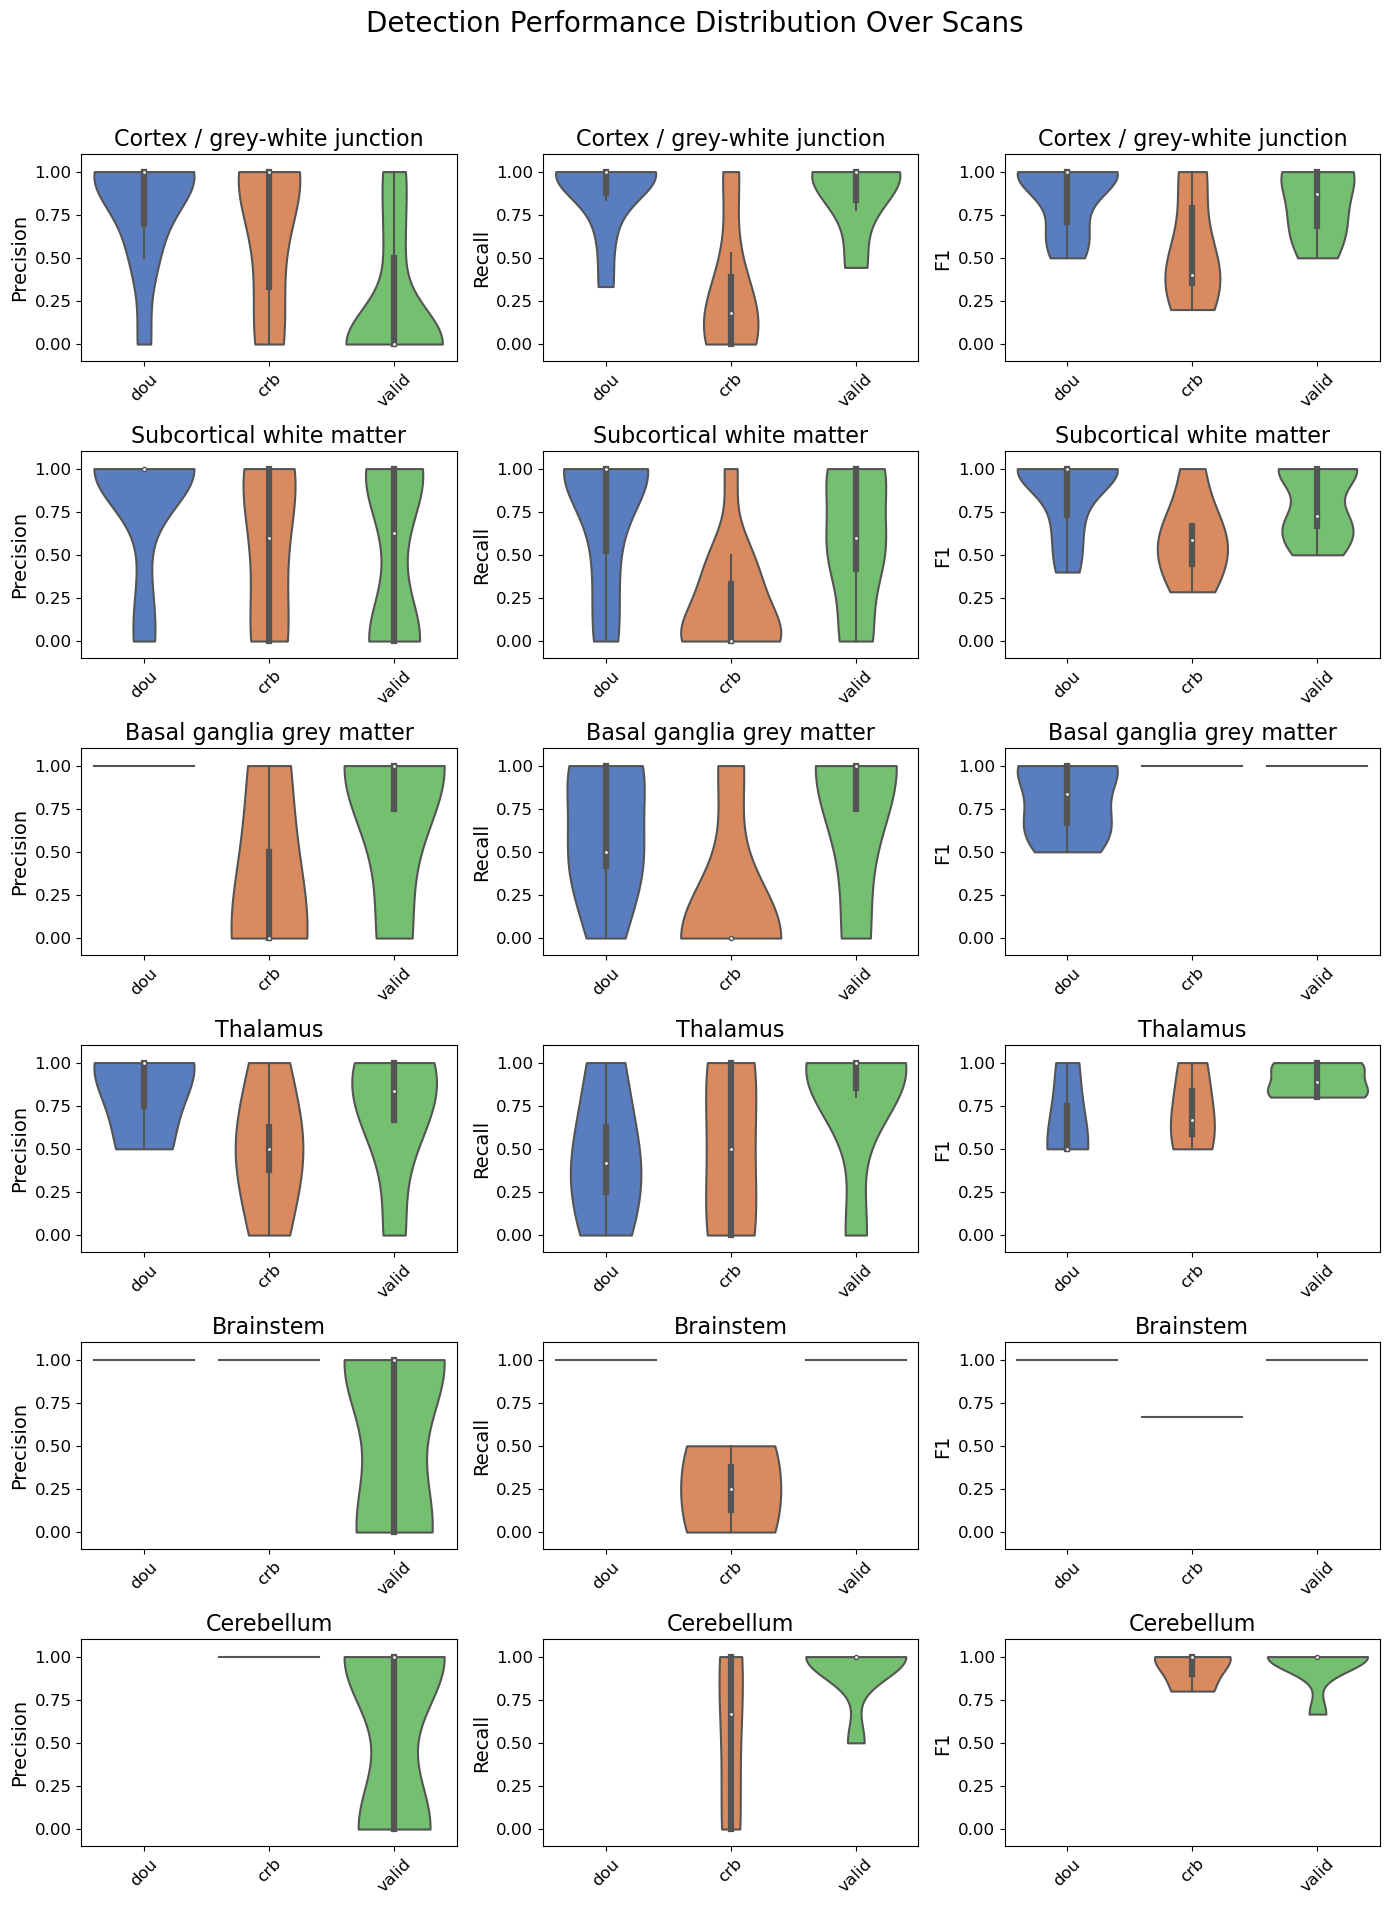

In [13]:
metrics = ["Precision", "Recall", "F1"]
# metrics = ["n_pred_cmb", "TP",	"FP",	"FN"]
locations = [
    "Cortex / grey-white junction",
    "Subcortical white matter",
    "Basal ganglia grey matter",
    "Thalamus",
    "Brainstem",
    "Cerebellum"
]

# Filter data for the specified model
df = df_detection_serieslevel_filt.copy()

# Setup figure and axes
fig, axs = plt.subplots(len(locations), len(metrics), figsize=(14,20))
fig.suptitle("Detection Performance Distribution Over Scans", fontsize=20)


# Iterate over locations and metrics to create a plot for each
for i, location in enumerate(locations):
    for j, metric in enumerate(metrics):
        # Filter the DataFrame for the current location and metric
        data_comb = df[(df["Location"] == location)]
        utils_plotting.create_violin_plot(
            data=data_comb,
            column=metric,
            group_by="Dataset",
            ax=axs[i,j], 
            order=datasets,
            title=f"{location}",
            xlabel="",
            ylabel=metric.capitalize(),
            rotation=45,
            fontsize_title=16,
            fontsize_labels=14,
            fontsize_ticks=12,
            palette="muted",  # Adding color palette
            cut=0,  # Cut parameter for the KDE to limit it beyond the range of the data
            showfliers=True,
            showmeans=False,  # Optionally display the means
            inner="box",  # Show quartiles within the violin
            y_lim=[-0.1,1.1],
        )
        
        # # Plotting the data
        # sns.violinplot(data=data_comb, x='Dataset', y='Value', ax=axs[i, j], order=datasets, palette="muted", cut=0, inner='box')
        # axs[i, j].set_title(f"{location}")
        # axs[i, j].set_xlabel('')
        # axs[i, j].set_ylabel(metric)

        # Check if data is completely empty and mark it as 'No Data'
        if data_comb[metric].isna().all():
            axs[i, j].text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].set_xlabel("Dataset")
            axs[i, j].set_ylabel("Value" if j == 0 else "")


# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../../data-misc/img/detection_performance_by_location.png")
plt.show()

/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

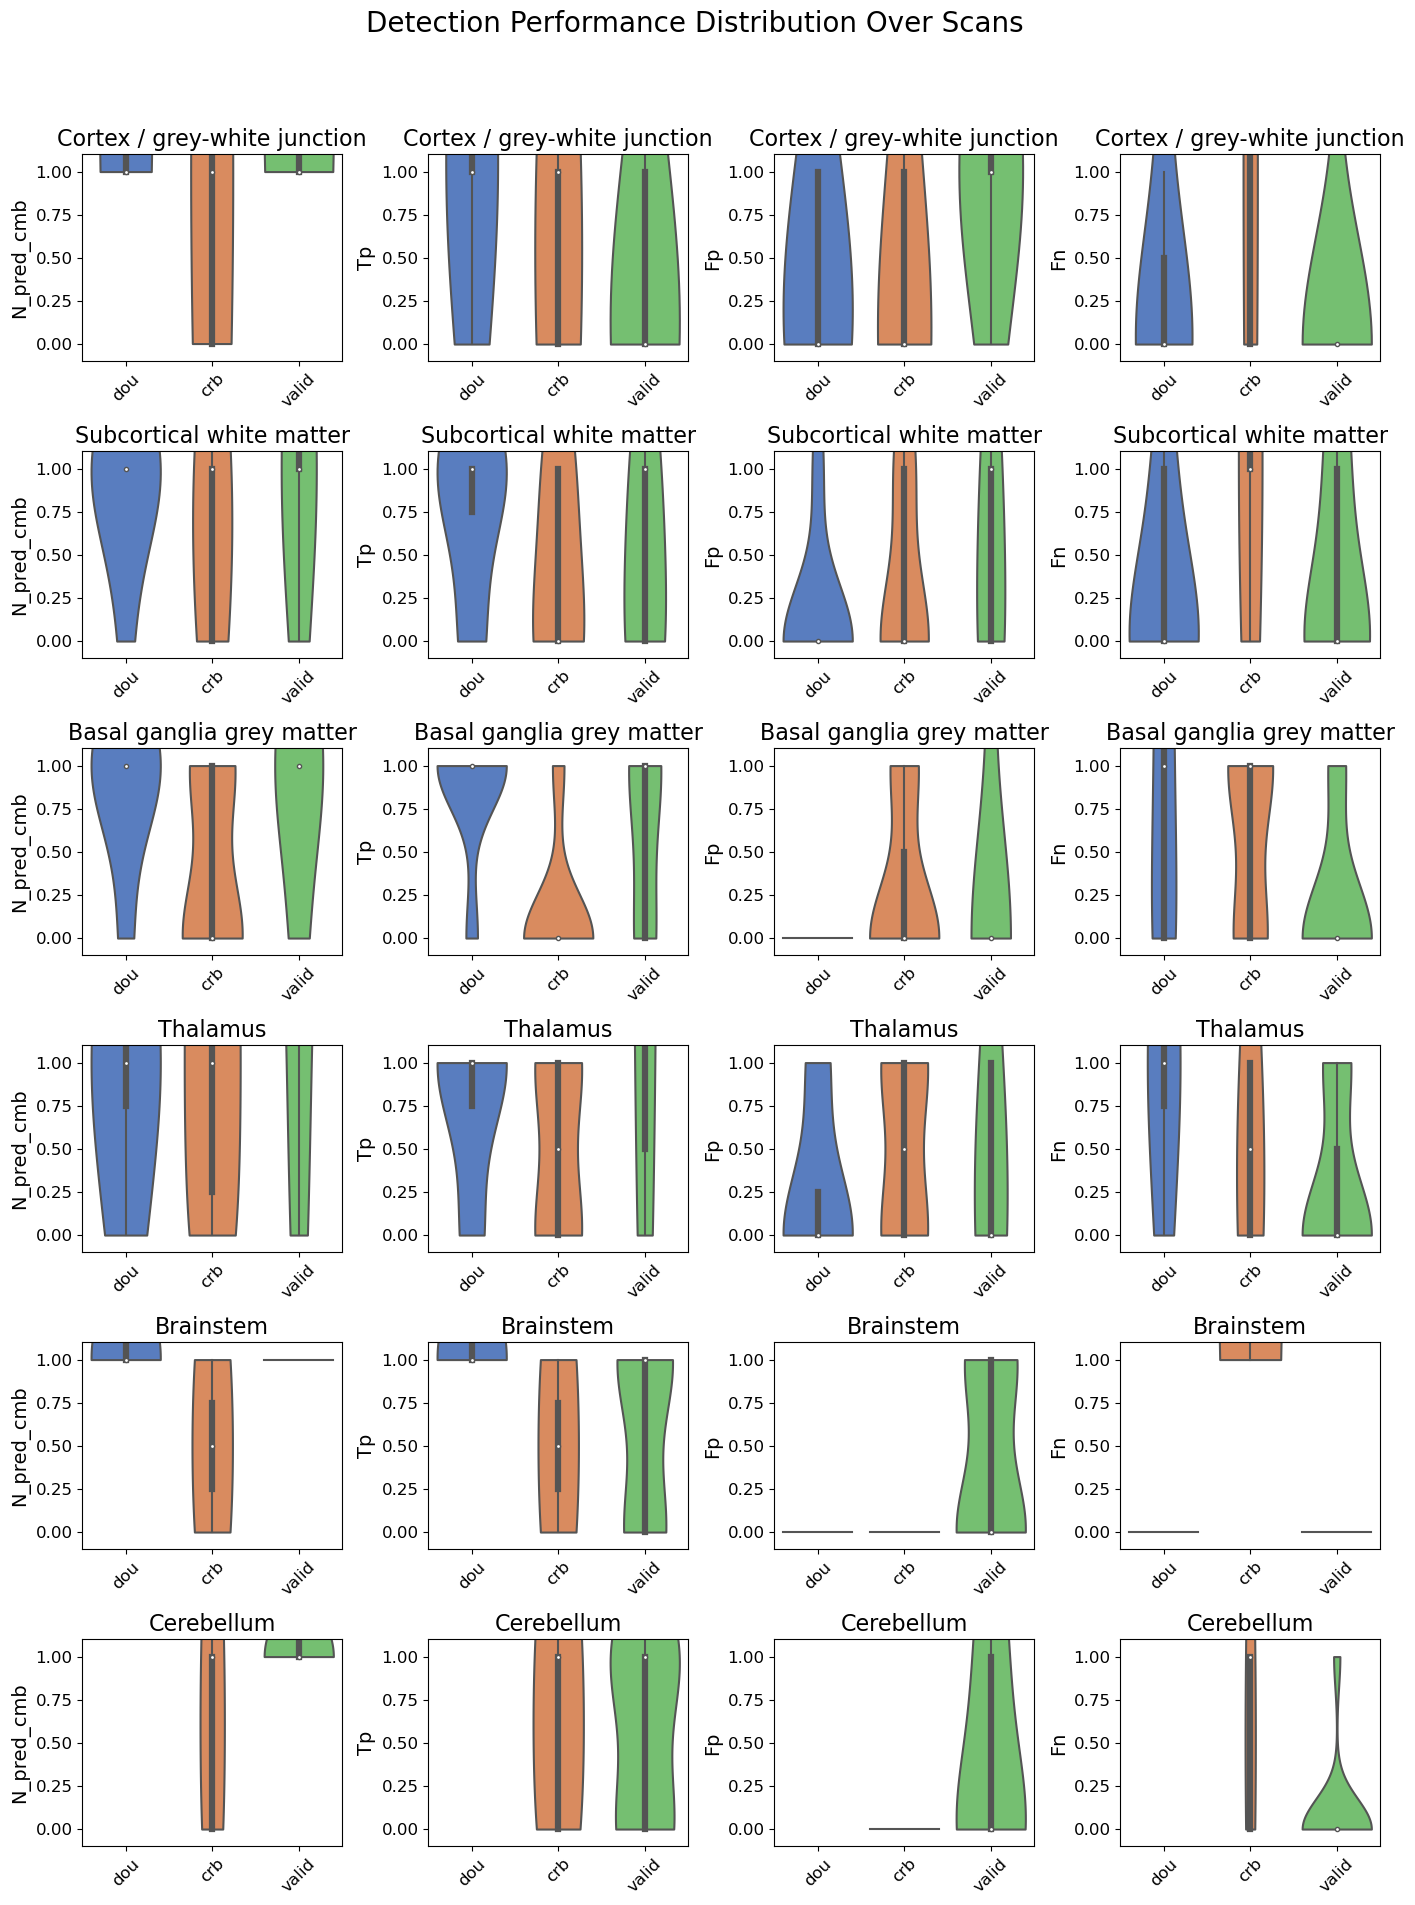

In [14]:
metrics = ["n_pred_cmb", "TP",	"FP",	"FN"]
locations = [
    "Cortex / grey-white junction",
    "Subcortical white matter",
    "Basal ganglia grey matter",
    "Thalamus",
    "Brainstem",
    "Cerebellum"
]

# Filter data for the specified model
df = df_detection_serieslevel_filt.copy()

# Setup figure and axes
fig, axs = plt.subplots(len(locations), len(metrics), figsize=(14,20))
fig.suptitle("Detection Performance Distribution Over Scans", fontsize=20)


# Iterate over locations and metrics to create a plot for each
for i, location in enumerate(locations):
    for j, metric in enumerate(metrics):
        # Filter the DataFrame for the current location and metric
        data_comb = df[(df["Location"] == location)]
        utils_plotting.create_violin_plot(
            data=data_comb,
            column=metric,
            group_by="Dataset",
            ax=axs[i,j], 
            order=datasets,
            title=f"{location}",
            xlabel="",
            ylabel=metric.capitalize(),
            rotation=45,
            fontsize_title=16,
            fontsize_labels=14,
            fontsize_ticks=12,
            palette="muted",  # Adding color palette
            cut=0,  # Cut parameter for the KDE to limit it beyond the range of the data
            showfliers=True,
            showmeans=False,  # Optionally display the means
            inner="box",  # Show quartiles within the violin
            y_lim=[-0.1,1.1],
        )
        
        # # Plotting the data
        # sns.violinplot(data=data_comb, x='Dataset', y='Value', ax=axs[i, j], order=datasets, palette="muted", cut=0, inner='box')
        # axs[i, j].set_title(f"{location}")
        # axs[i, j].set_xlabel('')
        # axs[i, j].set_ylabel(metric)

        # Check if data is completely empty and mark it as 'No Data'
        if data_comb[metric].isna().all():
            axs[i, j].text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].set_xlabel("Dataset")
            axs[i, j].set_ylabel("Value" if j == 0 else "")


# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../../data-misc/img/detection_performance_by_location.png")
plt.show()

/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

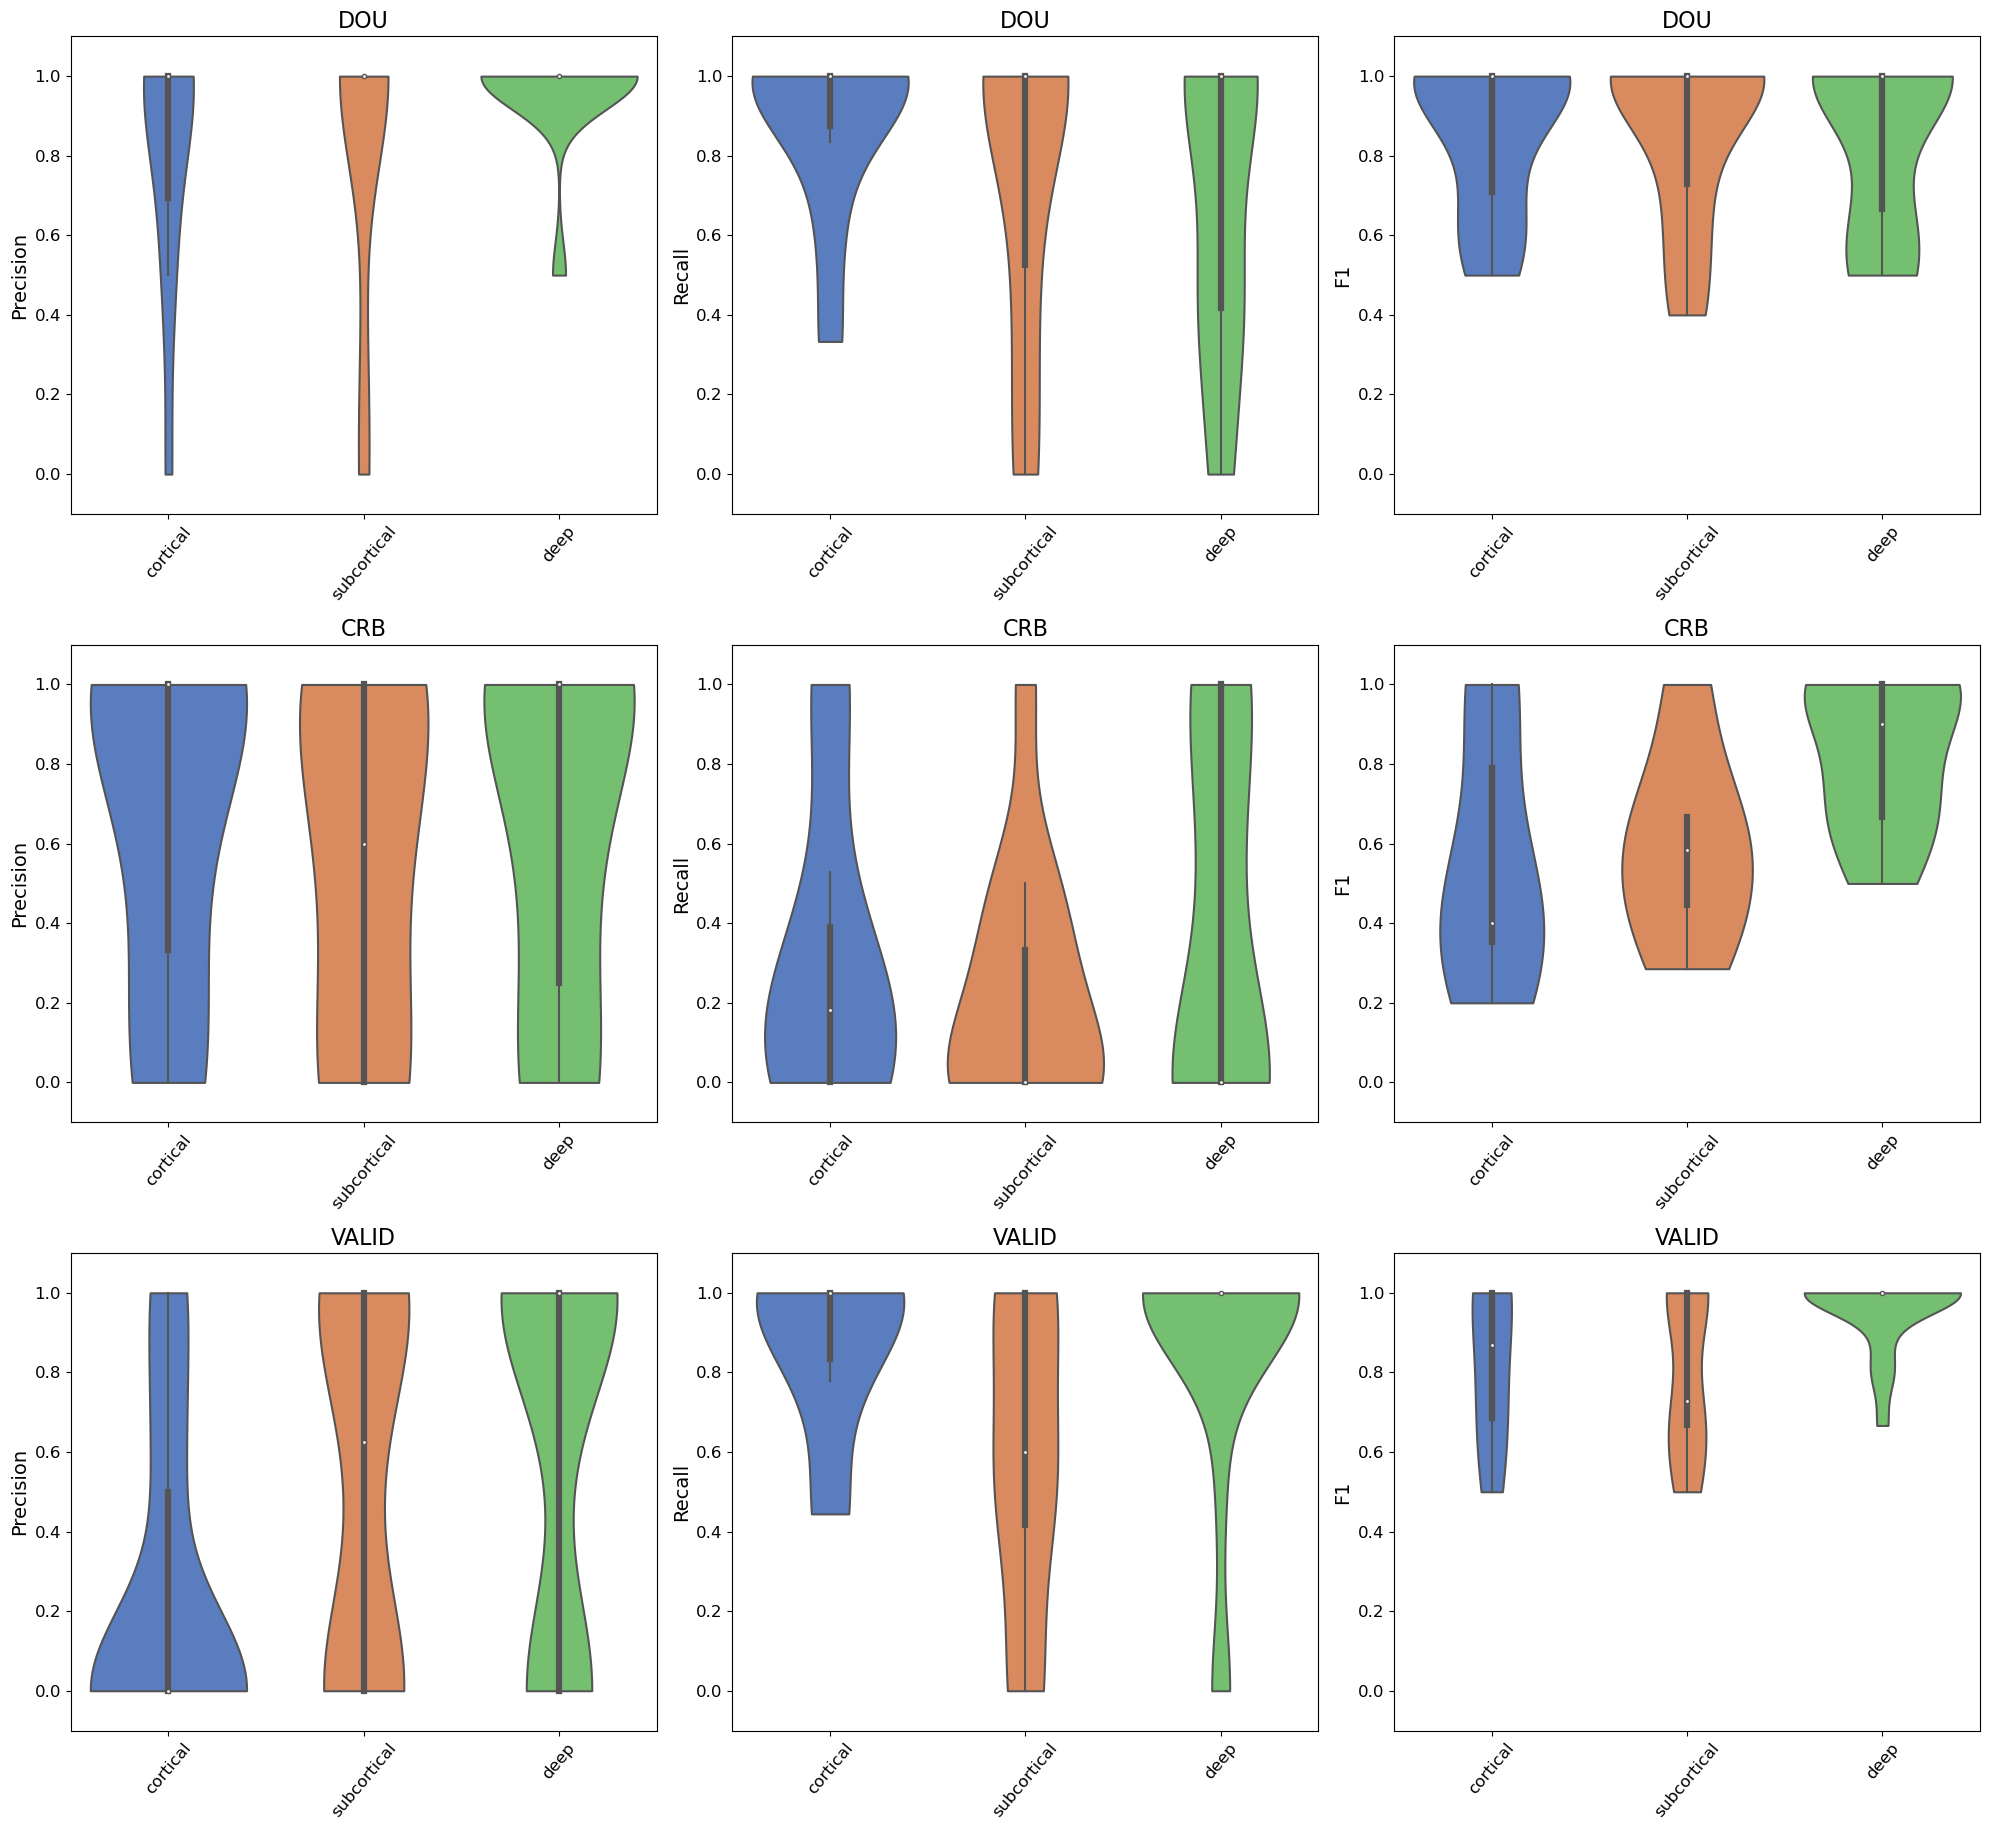

In [17]:
metrics = ["Precision", "Recall", "F1"]
# metrics = ["n_pred_cmb", "TP",	"FP",	"FN"]
locations = [
    "Cortex / grey-white junction",
    "Subcortical white matter",
    "Basal ganglia grey matter",
    "Thalamus",
    "Brainstem",
    "Cerebellum"
]

# Filter data for the specified model
df = df_detection_serieslevel_filt.copy()

# Setup figure and axes
fig, axs = plt.subplots(len(datasets), len(metrics), figsize=(20,20))
# fig.suptitle("Detection Performance Distribution Over Scans", fontsize=20)


df['Location_high'] = df['Location'].apply(
    lambda x:
        "cortical"
        if x == "Cortex / grey-white junction"
        else "subcortical"
        if x == "Subcortical white matter"
        else "deep"
)

# Iterate over locations and metrics to create a plot for each
for i, dataset in enumerate(datasets):
    for j, metric in enumerate(metrics):
        # Filter the DataFrame for the current location and metric
        data_comb = df[(df["Dataset"] == dataset)]
        utils_plotting.create_violin_plot(
            data=data_comb,
            column=metric,
            group_by='Location_high',
            ax=axs[i,j], 
            order=["cortical", "subcortical", "deep"],
            title=f"{dataset.upper()}",
            xlabel="",
            ylabel=metric.capitalize(),
            rotation=50,
            fontsize_title=16,
            fontsize_labels=14,
            fontsize_ticks=12,
            palette="muted",  # Adding color palette
            cut=0,  # Cut parameter for the KDE to limit it beyond the range of the data
            showfliers=True,
            showmeans=False,  # Optionally display the means
            inner="box",  # Show quartiles within the violin
            y_lim=[-0.1,1.1],
        )
        
        # # Plotting the data
        # sns.violinplot(data=data_comb, x='Dataset', y='Value', ax=axs[i, j], order=datasets, palette="muted", cut=0, inner='box')
        # axs[i, j].set_title(f"{location}")
        # axs[i, j].set_xlabel('')
        # axs[i, j].set_ylabel(metric)

        # Check if data is completely empty and mark it as 'No Data'
        if data_comb[metric].isna().all():
            axs[i, j].text(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].set_xlabel("Dataset")
            axs[i, j].set_ylabel("Value" if j == 0 else "")


# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../../data-misc/img/detection_performance_by_location.png")
plt.show()